# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [68]:
# Your code here
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/boston_data.csv')

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

In [69]:
df.corr()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000000,-0.194770,0.404249,-0.060688,0.405290,-0.172226,0.349288,-0.376493,0.603044,0.565047,0.292092,-0.377436,0.428940,-0.400956
zn,-0.194770,1.000000,-0.532268,-0.037290,-0.497114,0.302404,-0.546587,0.659018,-0.311313,-0.289332,-0.371315,0.176350,-0.412075,0.355608
indus,0.404249,-0.532268,1.000000,0.059928,0.760913,-0.353589,0.630048,-0.702583,0.616375,0.722828,0.356549,-0.378189,0.608309,-0.501698
chas,-0.060688,-0.037290,0.059928,1.000000,0.100650,0.090146,0.084852,-0.103124,-0.022561,-0.043708,-0.121835,0.042580,-0.041061,0.141400
nox,0.405290,-0.497114,0.760913,0.100650,1.000000,-0.266114,0.728882,-0.762469,0.612115,0.660607,0.166715,-0.393876,0.587573,-0.439225
rm,-0.172226,0.302404,-0.353589,0.090146,-0.266114,1.000000,-0.210589,0.178700,-0.173222,-0.241733,-0.323330,0.128410,-0.578025,0.683541
age,0.349288,-0.546587,0.630048,0.084852,0.728882,-0.210589,1.000000,-0.734915,0.467341,0.503830,0.231820,-0.276469,0.602001,-0.390863
dis,-0.376493,0.659018,-0.702583,-0.103124,-0.762469,0.178700,-0.734915,1.000000,-0.503471,-0.526938,-0.206016,0.306445,-0.500912,0.264876
rad,0.603044,-0.311313,0.616375,-0.022561,0.612115,-0.173222,0.467341,-0.503471,1.000000,0.917344,0.487733,-0.468700,0.499279,-0.423508
tax,0.565047,-0.289332,0.722828,-0.043708,0.660607,-0.241733,0.503830,-0.526938,0.917344,1.000000,0.465997,-0.462250,0.542732,-0.495792


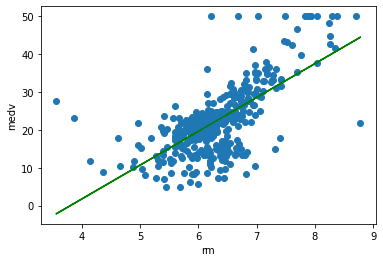

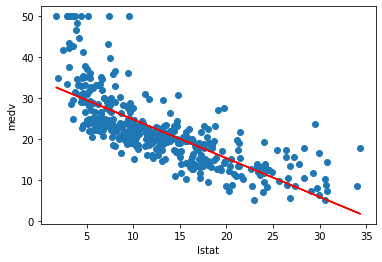

In [70]:
# column 'rm' 0.68 corr
# column 'lstat' 0.74 corr

x1 = df['rm']
y1 = df['medv']

x2 = df['lstat']
y2 = df['medv']

results1 = stats.linregress(x1,y1)
results1

results2 = stats.linregress(x2,y2)
results2

regression_line1 = results1.intercept + results1.slope*x1

regression_line2 = results2.intercept + results2.slope*x2

plt.plot(x1, regression_line1, c = 'green')
plt.scatter(x1,y1)
plt.xlabel('rm')
plt.ylabel('medv')
plt.show()

plt.plot(x2, regression_line2, c = 'red')
plt.scatter(x2,y2)
plt.xlabel('lstat')
plt.ylabel('medv')
plt.show()

In [71]:
# Your plots here
display(df.head())
display(df.shape)
display(df.describe())
display(df.isna().sum())
df.info()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


(404, 14)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.730912,10.509901,11.189901,0.069307,0.556710,6.30145,68.601733,3.799666,9.836634,411.688119,18.444554,355.068243,12.598936,22.312376
std,8.943922,22.053733,6.814909,0.254290,0.117321,0.67583,28.066143,2.109916,8.834741,171.073553,2.150295,94.489572,6.925173,8.837019
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.56100,2.900000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082382,0.000000,5.190000,0.000000,0.453000,5.90275,45.800000,2.087875,4.000000,281.000000,17.375000,374.710000,7.135000,17.100000
50%,0.253715,0.000000,9.795000,0.000000,0.538000,6.23050,76.600000,3.207450,5.000000,330.000000,19.000000,391.065000,11.265000,21.400000
75%,4.053158,12.500000,18.100000,0.000000,0.631000,6.62925,94.150000,5.222125,24.000000,666.000000,20.200000,396.007500,16.910000,25.000000
max,88.976200,95.000000,27.740000,1.000000,0.871000,8.78000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,34.370000,50.000000


crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   nox      404 non-null    float64
 5   rm       404 non-null    float64
 6   age      404 non-null    float64
 7   dis      404 non-null    float64
 8   rad      404 non-null    float64
 9   tax      404 non-null    float64
 10  ptratio  404 non-null    float64
 11  black    404 non-null    float64
 12  lstat    404 non-null    float64
 13  medv     404 non-null    float64
dtypes: float64(14)
memory usage: 44.2 KB


### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [72]:
# Your response here
# the x axis are qualities from the suburbs of Boston
# it appears that as lstat goes up medv goes down, which means that they are negatively correlated -0.74
# it appears that as rm goes up medv goes up also, which means that they are positively correlated +0.68

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

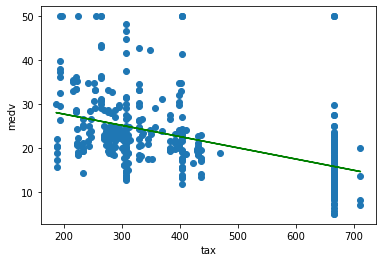

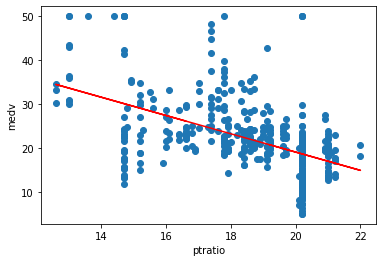

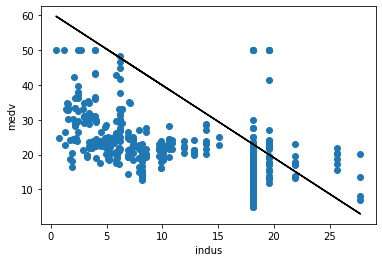

In [73]:
#the maximum correlated abs values of the other variables excluding lstat and rm 
#are tax, ptratio and indus
x1 = df['tax']
y1 = df['medv']

x2 = df['ptratio']
y2 = df['medv']

x3 = df['indus']
y3 = df['medv']

results1 = stats.linregress(x1,y1)
results1

results2 = stats.linregress(x2,y2)
results2

results3 = stats.linregress(x2,y2)
results3

regression_line1 = results1.intercept + results1.slope*x1

regression_line2 = results2.intercept + results2.slope*x2

regression_line3 = results3.intercept + results3.slope*x3

plt.plot(x1, regression_line1, c = 'green')
plt.scatter(x1,y1)
plt.xlabel('tax')
plt.ylabel('medv')
plt.show()

plt.plot(x2, regression_line2, c = 'red')
plt.scatter(x2,y2)
plt.xlabel('ptratio')
plt.ylabel('medv')
plt.show()

plt.plot(x3, regression_line3, c = 'black')
plt.scatter(x3,y3)
plt.xlabel('indus')
plt.ylabel('medv')
plt.show()



#negative correlations of around 0.5


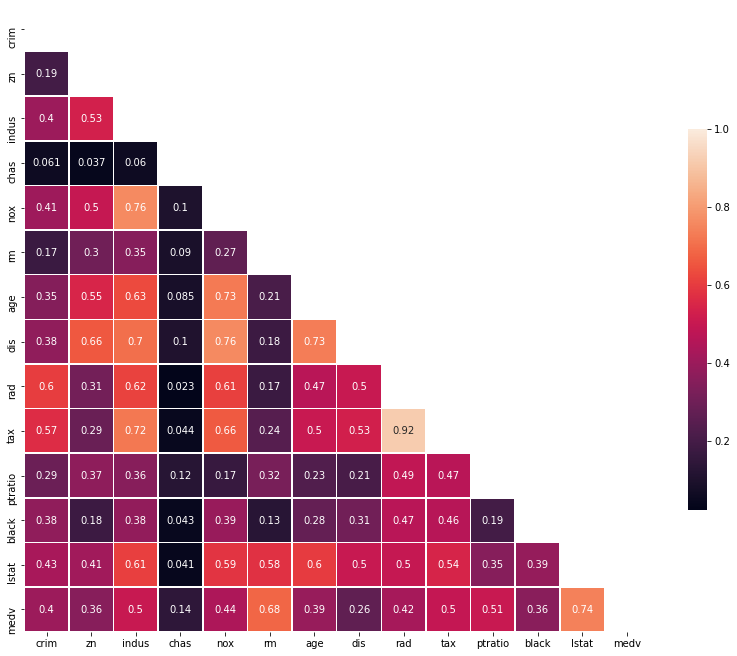

In [74]:
# Your response here
corr=np.abs(df.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 14))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [75]:
# Your code here
df['medv'].describe()

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [76]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_pred)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [79]:
# Your code here
features=list(df.columns)
features.remove('medv')
features
X=df[features]
y=df['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [116]:
# Five separate RFR here with the given max depths
from sklearn.ensemble import RandomForestRegressor
depth_var = [i for i in range(1,11) if i%2==0]

def forest_score_depth_variation(a_list):
    score_result = []
    for depth in a_list:
        forest = RandomForestRegressor(n_estimators=10, # trees
                                       max_depth=depth, # depth 
                                       random_state=1) # fixing random state
        forest.fit(X_train, y_train)
        score_result.append(round(forest.score(X_test,y_test), 7))
        results=zip(a_list, score_result)
    return list(results) #forest.score(X_test,y_test)

In [120]:
def forest_score_depth_variation2(a_list):
    score_result = []
    for depth in a_list:
        forest = RandomForestRegressor(n_estimators=10, # trees
                                       max_depth=depth, # depth 
                                       random_state=1) # fixing random state
        forest.fit(X_train, y_train)
        score_result.append(round(forest.score(X_train,y_train), 7))
        results=zip(a_list, score_result)
    return list(results) #forest.score(X_test,y_test)

In [117]:
forest_score_depth_variation(depth_var)

[(2, 0.6551693),
 (4, 0.764687),
 (6, 0.7750618),
 (8, 0.7701787),
 (10, 0.7817865)]

Now, plot the score for each tree on the training set and on the testing set.

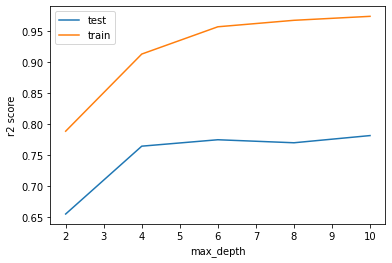

In [129]:
x,y = zip(*forest_score_depth_variation(depth_var))
z,r = zip(*forest_score_depth_variation2(depth_var))
plt.plot(x, y, label='test')
plt.plot(z, r, label='train')
plt.xlabel('max_depth')
plt.ylabel('r2 score')
plt.legend()
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here
#As we increase the max_depth of the model 'RandomForestRegressor' our r2score increases, 
#r2score is bigger on the training set because our model was trained on it

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here

#We have variance problems it seems so:

#'As a result, such models 
#perform very well on training data but has high error rates on test data.'
#Which is the case

#When the model is trained with a max depth of 1 we are getting a bias model and a high variance problems
#With a max depth of 10 we lower the bias on our model but the variance problem is still there



### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [133]:
# Your response here
from sklearn.model_selection import RandomizedSearchCV

forest = RandomForestRegressor(random_state=1) #not defining any hyperparameters
forest.fit(X_train, y_train)

# let us consider a large space of parameters
# go find parameters to optimize https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split <- a non-numeric parameter, no problem. Could also have been used in gridsearch
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None) #<- plus no cap
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_search = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 10, cv = 5, n_jobs = 10)

In [134]:
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [135]:
random_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [136]:
random_search.best_score_

0.8649685581037285

In [137]:
random_search.score(X_test, y_test)
#High variance

0.7951459658196088

In [146]:
forest = RandomForestRegressor(n_estimators=1200,
                               min_samples_split=5,
                               min_samples_leaf=1,
                               max_features='sqrt',
                               bootstrap=False,
                               max_depth=200,
                               random_state=1)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.7951459658196088

In [149]:
from sklearn.model_selection import GridSearchCV

max_depth = [i for i in range(1,50)]

grid = {'n_estimators': [1200],
        'min_samples_split' : [5],
        'min_samples_leaf' : [1],
        'max_features': ['sqrt'],
        'bootstrap':[False],
        'max_depth':max_depth,
        'random_state':[1]
       }

forest = RandomForestRegressor()

grid_search = GridSearchCV(estimator = forest, param_grid = grid, cv = 5)
grid_search.fit(X_train, y_train)
grid_search.best_score_

0.8649850523667629

In [150]:
grid_search.best_params_

#it seems 20 as max depth is the best value, bot according to the random_seach is None! Im confused

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1200,
 'random_state': 1}

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here
#Ancient data is not a good starting base, economic paradigms had changed already and the world is in constant change
#I dont think that numerical values only can describe a good way of calculating house value
#No, there is too much variance in it, and not so high accuracy 0.86
#Not really, these 2 zones are dependant of different variables
#As would my friend Dennis say "There aren't 2 places equal"